#   Does Speed Kill…Base Hits?
## Exploring acceleration as a proxy for defensive ability

by Ethan Rendon

# Import modules used in program

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import plotly.express as px
import seaborn as sns
from scipy.spatial import distance
import math

Mounted at /content/drive


# Load data (if running on local server replace file names)

In [2]:
ball_pos=pd.read_csv('/content/drive/MyDrive/smt comp/ball_pos.csv',on_bad_lines='skip')
ball_pos = ball_pos.rename(columns = {'ball_position_x':'field_x','ball_position_y':'field_y','ball_position_z':'field_z'})
print('Size of ball_pos',len(ball_pos))
game_events=pd.read_csv('/content/drive/MyDrive/smt comp/game_events.csv',on_bad_lines='skip')
print('Size of game_events',len(game_events))
game_info=pd.read_csv('/content/drive/MyDrive/smt comp/game_info.csv',on_bad_lines='skip')
print('Size of game_info',len(game_info))
player_pos=pd.read_csv('/content/drive/MyDrive/smt comp/player_pos.csv',on_bad_lines='skip')
print('Size of player_pos',len(player_pos))
team_info=pd.read_csv('/content/drive/MyDrive/smt comp/team_info.csv',on_bad_lines='skip')
print('Size of team_info',len(team_info))
full_pos = pd.concat([player_pos,ball_pos])
full_pos['new_id'] = full_pos['game_str'] + full_pos['play_id'].astype(str)
print('Size of full_pos',len(full_pos))
full_pos["player_position"].fillna(0, inplace = True)

Size of ball_pos 785041
Size of game_events 103444
Size of game_info 26315
Size of player_pos 20305730
Size of team_info 1039
Size of full_pos 21090771


# Run for One Player

In [3]:
playcount = game_info.groupby('center_field').size().to_csv('playcount.csv')
playcount=pd.read_csv('/content/playcount.csv',on_bad_lines='skip')
playcount = playcount.rename(columns={"0": "count"})
player1 = playcount.iloc[1]['center_field']
player1_game = game_info.query(f'center_field == {player1}')
gameunique = player1_game['game_str'].unique()
guli = list(gameunique)
len(gameunique)

13

In [4]:
game = game_events
game = game.query(f'game_str == @guli')
pos = full_pos
pos = pos.query(f'game_str==@guli')

In [ ]:
player1_plays = pd.DataFrame({'center_field':[],'game_str':[],
        'play_id':[],
        'play_per_game':[],
        'line_distance':[],
        'full_distance':[],
        'route_efficiency':[],
        'time_delta':[],
        'avg_speed':[],
        'first_step_speed':[],
        'first_step_check':[],
        'hang_time':[],
        'catch_difficulty':[],
        'easy_catch':[]
       } )

for i in range(len(guli)):

  loophold = game.query(f'game_str == "{guli[i]}"').sort_values(by='play_per_game').reset_index().drop(columns=['index','at_bat'])

  for index, row in loophold.iterrows(): 
      # If ball bounce > 150 from player at start of play remove 
      # If bounce or not store in column 

    if loophold.iat[index,4] == 10 and loophold.iat[index,5] == 4 and loophold.iat[index+1,4] == 8 and loophold.iat[index+1,5] == 2: 

      # Fielder position at time of contact
      contactCF_pos = pos.query(f'play_id == {loophold.iat[index,1]} and game_str == "{loophold.iat[index,0]}" and player_position == 8 and timestamp == {loophold.iat[index,3]}') 
      fielder_x_contact = contactCF_pos['field_x'].values
      fielder_y_contact = contactCF_pos['field_y'].values
        
      # Ball position at time of catch
      catch_pos = pos.query(f'play_id == {loophold.iat[index+1,1]} and game_str == "{loophold.iat[index+1,0]}" and player_position == 0 and timestamp == {loophold.iat[index+1,3]}') 
      ball_x_catch = catch_pos['field_x'].values
      ball_y_catch = catch_pos['field_y'].values

      # Ball position at time of contact
      contact_pos1 = pos.query(f'play_id == {loophold.iat[index,1]} and game_str == "{loophold.iat[index,0]}" and player_position == 0')
      contact_pos = pos.query(f'play_id == {loophold.iat[index,1]} and game_str == "{loophold.iat[index,0]}" and player_position == 0 and timestamp == {loophold.iat[index,3]}') 
      ball_x_contact= contact_pos['field_x'].values
      ball_y_contact = contact_pos['field_y'].values

      if len(contact_pos1) > 50: # limit properly tagged data ~ 50 frames the data is actually a ball hit to CF and caught

        # Calculate distance between fielder position at contact and ball position at point of catch (range is max)
        x0,x1,y0,y1 = fielder_x_contact,ball_x_catch,fielder_y_contact,ball_y_catch
        line_distance = math.sqrt( ((x0-x1)**2)+((y0-y1)**2) )

        # Calculate full distance fielder traveled over play
        posfilter = pos.query(f'play_id == {loophold.iat[index,1]} and game_str == "{loophold.iat[index,0]}" and player_position == 8').sort_values(by='timestamp',ascending=True) # filter position data
        posfilter['timestamp'] = posfilter['timestamp'] / 1000 # convert to seconds
        posfilter['dist'] = 0 # intialize new column for distance

        for j in range(len(posfilter)):
          try:
            x0,y0,x1,y1 = posfilter.iat[j,4], posfilter.iat[j,5], posfilter.iat[j+1,4], posfilter.iat[j+1,5] # apply distance formula to current row and current row + 1 points
            posfilter.iat[j,8] = math.sqrt( ((x0-x1)**2)+((y0-y1)**2))

          except IndexError: # stop from crashing at max because there is no i+1 row after the last row
            pass

        full_distance = posfilter['dist'].sum()

        # Route efficiency formula is line / full distance
        route_efficiency = line_distance / full_distance

        # Delta in time of play
        time_delta = (posfilter['timestamp'].max() - posfilter['timestamp'].min())

        # AVG Speed (ft/s) 
        avg_speed = full_distance / time_delta

        # VECTOR
        first_step_check = 0
        vector = posfilter.query('dist > 0.1').sort_values(by='timestamp',ascending=True).head(20).sort_values(by='timestamp',ascending=True) # @ 0.1 cutoff for speed increase, 20 is 1 of data
        if len(vector) > 0:
          
          #Speed of first step
          x0,y0,x1,y1 = vector.iat[0,4],vector.iat[0,5],vector.iat[19,4],vector.iat[19,5]
          first_step_speed = math.sqrt( ((x0-x1)**2)+((y0-y1)**2)) 

          vector_last = vector.tail(1)
          x0,y0,x1,y1 = vector_last['field_x'],vector_last['field_y'],ball_x_catch,ball_y_catch
          vector_check = math.sqrt( ((x0-x1)**2)+((y0-y1)**2))

          # if fielder is making efficient first step output 1 meaning that fielder is getting closer to ball position  
          if vector_check < line_distance:  
            first_step_check = 1
        else:
          first_step_speed = 'NaN'

        # HANG TIME
        hang_time = len(contact_pos1)/20 # every 20 rows is 1 second

        # CATCH DIFF
        point = (line_distance,hang_time)
        constant = (.0409091*point[0])+1.77273 # above are catches made >50% of the time below is less
        if point[1] > constant: 
          easy_catch = 1 # if ball is > 50% == easy 
        else:
          easy_catch = 0
        catch_difficulty = 100 - (100 * point[1]/constant)
        if catch_difficulty < 0: # catch (hahahaha) all the catches are easier than 0 to floor then
          catch_difficulty = 0 

      
        # Update DataFrame with real values!
        if route_efficiency < 1 and avg_speed < 32 : # to remove mislabeled data as there is a pitch solely between pitcher and catcher that is tagged as CF catching ball
          player1_plays.loc[len(player1_plays.index)] = [
              loophold.iat[index,0], # game_str
              loophold.iat[index,1], # play_id
              loophold.iat[index,2], # play_per_game
              line_distance,
              full_distance,
              route_efficiency,
              time_delta, 
              avg_speed,
              first_step_speed,
              first_step_check,
              hang_time,
              catch_difficulty,
              easy_catch
              ]

# RANGE is max line_distance == caught
range = player1_plays['line_distance'].max()
print("RANGE:",range)

# AVG Speed is AVG of all AVGs
speedavg = player1_plays['avg_speed'].mean()
print("Avg Speed:",speedavg)

# Peak Speed is MAX of all AVGs
speedmax = player1_plays['avg_speed'].max()
print("Max Speed:",speedmax)

# AVG first step speed
first_step_speedavg = player1_plays['first_step_speed'].mean()
print("Avg Speed on 1st Step:",first_step_speedavg)

# AVG catch difficulty
avgcatchdiff = player1_plays['catch_difficulty'].mean()
print("Avg Catch Diff:",avgcatchdiff)

# Good first step%
firststeprate = 100 * (player1_plays['first_step_check'].sum() / len(player1_plays))
print("Good First Step%:",firststeprate)

# Easy_catch% -> can also do easy catch% made
easycatchrate = 100 * (player1_plays['easy_catch'].sum() / len(player1_plays))
print("Easy Catch%:",easycatchrate)

display(player1_plays)

# Run for Multiple players

In [ ]:
playcount = game_info.groupby('center_field').size().to_csv('playcount.csv')
playcount = pd.read_csv('/content/playcount.csv',on_bad_lines='skip')
playcount = playcount.rename(columns={"0": "count"})
playcount = playcount.query('count > 400') # constrain top fielders with top 20 most plays

In [ ]:
player1_plays = pd.DataFrame({'center_field':[],'game_str':[],
        'play_id':[],
        'play_per_game':[],
        'line_distance':[],
        'full_distance':[],
        'route_efficiency':[],
        'time_delta':[],
        'avg_speed':[],
        'first_step_speed':[],
        'first_step_check':[],
        'hang_time':[],
        'catch_difficulty':[],
        'easy_catch':[]
       } )
career_stats = pd.DataFrame({'center_field':[],
          'range':[],
          'route_efficiency':[],
          'speed':[],
          'max_speed':[],
          'first_step_speed':[],
          'catch_difficulty':[],
          'first_step_rate':[],
          'easy_catch_rate':[]
        } )   

for q in range(len(playcount)):

  print(q)
  id = playcount.iloc[q]['center_field']
  player1_game = game_info.query(f'center_field == {id}')
  gameunique = player1_game['game_str'].unique()
  guli = list(gameunique)
  game = game_events
  game = game.query(f'game_str == @guli')
  for i in range(len(guli)):

    loophold = game.query(f'game_str == "{guli[i]}"').sort_values(by='play_per_game').reset_index().drop(columns=['index','at_bat'])

    for index, row in loophold.iterrows(): 
        # If ball bounce > 150 from player at start of play remove 
        # If bounce or not store in column 

      if loophold.iat[index,4] == 10 and loophold.iat[index,5] == 4 and loophold.iat[index+1,4] == 8 and loophold.iat[index+1,5] == 2: 

        # Fielder position at time of contact
        contactCF_pos = pos.query(f'play_id == {loophold.iat[index,1]} and game_str == "{loophold.iat[index,0]}" and player_position == 8 and timestamp == {loophold.iat[index,3]}') 
        fielder_x_contact = contactCF_pos['field_x'].values
        fielder_y_contact = contactCF_pos['field_y'].values
          
        # Ball position at time of catch
        catch_pos = pos.query(f'play_id == {loophold.iat[index+1,1]} and game_str == "{loophold.iat[index+1,0]}" and player_position == 0 and timestamp == {loophold.iat[index+1,3]}') 
        ball_x_catch = catch_pos['field_x'].values
        ball_y_catch = catch_pos['field_y'].values

        # Ball position at time of contact
        contact_pos1 = pos.query(f'play_id == {loophold.iat[index,1]} and game_str == "{loophold.iat[index,0]}" and player_position == 0')
        contact_pos = pos.query(f'play_id == {loophold.iat[index,1]} and game_str == "{loophold.iat[index,0]}" and player_position == 0 and timestamp == {loophold.iat[index,3]}') 
        ball_x_contact= contact_pos['field_x'].values
        ball_y_contact = contact_pos['field_y'].values

        if len(contact_pos1) > 50: # limit properly tagged data ~ 50 frames the data is actually a ball hit to CF and caught

          # Calculate distance between fielder position at contact and ball position at point of catch (range is max)
          x0,x1,y0,y1 = fielder_x_contact,ball_x_catch,fielder_y_contact,ball_y_catch
          line_distance = math.sqrt( ((x0-x1)**2)+((y0-y1)**2) )

          # Calculate full distance fielder traveled over play
          posfilter = pos.query(f'play_id == {loophold.iat[index,1]} and game_str == "{loophold.iat[index,0]}" and player_position == 8').sort_values(by='timestamp',ascending=True) # filter position data
          posfilter['timestamp'] = posfilter['timestamp'] / 1000 # convert to seconds
          posfilter['dist'] = 0 # intialize new column for distance

          for j in range(len(posfilter)):
            try:
              x0,y0,x1,y1 = posfilter.iat[j,4], posfilter.iat[j,5], posfilter.iat[j+1,4], posfilter.iat[j+1,5] # apply distance formula to current row and current row + 1 points
              posfilter.iat[j,8] = math.sqrt( ((x0-x1)**2)+((y0-y1)**2))

            except IndexError: # stop from crashing at max because there is no i+1 row after the last row
              pass

          full_distance = posfilter['dist'].sum()

          # Route efficiency formula is line / full distance
          route_efficiency = line_distance / full_distance

          # Delta in time of play
          time_delta = (posfilter['timestamp'].max() - posfilter['timestamp'].min())

          # AVG Speed (ft/s) 
          avg_speed = full_distance / time_delta

          # VECTOR
          first_step_check = 0
          vector = posfilter.query('dist > 0.1').sort_values(by='timestamp',ascending=True).head(20).sort_values(by='timestamp',ascending=True) # @ 0.1 cutoff for speed increase, 20 is 1 of data
          if len(vector) > 0:
            
            #Speed of first step
            x0,y0,x1,y1 = vector.iat[0,4],vector.iat[0,5],vector.iat[19,4],vector.iat[19,5]
            first_step_speed = math.sqrt( ((x0-x1)**2)+((y0-y1)**2)) 

            vector_last = vector.tail(1)
            x0,y0,x1,y1 = vector_last['field_x'],vector_last['field_y'],ball_x_catch,ball_y_catch
            vector_check = math.sqrt( ((x0-x1)**2)+((y0-y1)**2))

            # if fielder is making efficient first step output 1 meaning that fielder is getting closer to ball position  
            if vector_check < line_distance:  
              first_step_check = 1
          else:
            first_step_speed = 'NaN'

          # HANG TIME
          hang_time = len(contact_pos1)/20 # every 20 rows is 1 second

          # CATCH DIFF
          point = (line_distance,hang_time)
          constant = (.0409091*point[0])+1.77273 # above are catches made >50% of the time below is less
          if point[1] > constant: 
            easy_catch = 1 # if ball is > 50% == easy 
          else:
            easy_catch = 0
          catch_difficulty = 100 - (100 * point[1]/constant)
          if catch_difficulty < 0: # catch (hahahaha) all the catches are easier than 0 to floor then
            catch_difficulty = 0 

        
          # Update DataFrame with real values!
          if route_efficiency < 1 and avg_speed < 32 : # to remove mislabeled data as there is a pitch solely between pitcher and catcher that is tagged as CF catching ball

            player1_plays.at[len(player1_plays.index),'center_field'] = id
            player1_plays.at[len(player1_plays.index),'game_str'] = loophold.iat[index,0]
            player1_plays.at[len(player1_plays.index),'play_id'] = loophold.iat[index,1]
            player1_plays.at[len(player1_plays.index),'play_per_game'] = loophold.iat[index,2]
            player1_plays.at[len(player1_plays.index),'start_time'] = line_distance
            player1_plays.at[len(player1_plays.index),'end_time'] = full_distance
            player1_plays.at[len(player1_plays.index),'route_efficiency'] = route_efficiency
            player1_plays.at[len(player1_plays.index),'time_delta'] = time_delta
            player1_plays.at[len(player1_plays.index),'avg_speed'] = avg_speed
            player1_plays.at[len(player1_plays.index),'first_step_speed'] = first_step_speed
            player1_plays.at[len(player1_plays.index),'first_step_check'] = first_step_check
            player1_plays.at[len(player1_plays.index),'hang_time'] = hang_time
            player1_plays.at[len(player1_plays.index),'catch_difficulty'] = catch_difficulty
            player1_plays.at[len(player1_plays.index),'easy_catch'] = easy_catch
     
  career_stats.at[len(player1_plays.index),'center_field'] = id
  career_stats.at[len(player1_plays.index),'range'] = range = player1_plays['line_distance'].max() # RANGE is max line_distance == caught
  career_stats.at[len(player1_plays.index),'route_efficiency'] = player1_plays['route_efficiency'].mean()
  career_stats.at[len(player1_plays.index),'speed'] = player1_plays['avg_speed'].mean()
  career_stats.at[len(player1_plays.index),'max_speed'] = player1_plays['avg_speed'].max()
  career_stats.at[len(player1_plays.index),'first_step_speed'] = player1_plays['first_step_speed'].mean()
  career_stats.at[len(player1_plays.index),'catch_difficulty'] = player1_plays['catch_difficulty'].mean()
  career_stats.at[len(player1_plays.index),'first_step_rate'] = 100 * (player1_plays['first_step_check'].sum() / len(player1_plays))
  career_stats.at[len(player1_plays.index),'easy_catch_rate'] = 100 * (player1_plays['easy_catch'].sum() / len(player1_plays))  


career = career_stats.to_csv('career.csv')
topCF_plays = player1_plays.to('top20CF.csv')
display(player1_plays)

# Graphs used for Factor section of Paper


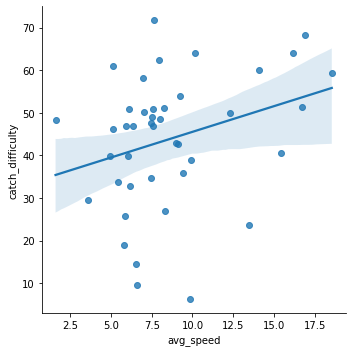

In [ ]:
sns.lmplot(data=player1_plays,x='avg_speed',y='catch_difficulty')

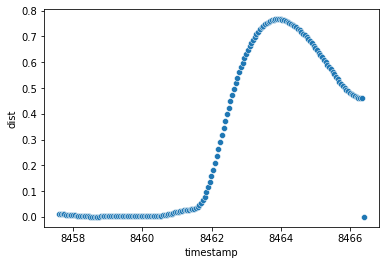

In [ ]:
posfilter['dist'] = posfilter['dist'].astype(float)
sns.scatterplot(data=posfilter,x='timestamp',y='dist')

## Animate one play on graph

In [ ]:
play = full_pos.query(f'new_id == "1902_24_TeamMA_TeamA1316"').sort_values(by='timestamp',ascending=True)
play["player_position"].fillna(0, inplace = True)
play = play.query('player_position < 13.5')
play["player_position"] = play["player_position"].map({0 : 'ball',1: 'pitcher',2:'catcher',3:'first baseman', 4:'second baseman',5:'third baseman',6:'shortstop',7:'left field',8:'center field',9:'right field',10:'batter',11:'runner1',12:'runner2',13:'runner3'})

ballloc = play.query('player_position == "ball"')
ballexist = play.query(f'player_position=="ball"')
mintime = ballexist['timestamp'].min()
maxtime = ballexist['timestamp'].max()
t = maxtime - mintime

start = ballexist.query(f'timestamp == {mintime}')
startcoord = [start['field_x'],start['field_y']]
end = ballexist.query(f'timestamp == {maxtime}')
endcoord = [end['field_x'],end['field_y']]
d = distance.euclidean(startcoord,endcoord)

t = t/3600000
d = d /5280


fig = px.scatter(play,x='field_x', y='field_y',color='player_position',animation_group='player_position',animation_frame='timestamp',range_x=[-250, 250])

fig.update_xaxes(visible=False) 
fig.update_yaxes(visible=False)

fig.update_layout(
                plot_bgcolor='rgba(56,93,51,255)')
fig.show()

# Graphs used for Analysis section of Paper

In [ ]:
real = player1_plays
real['name'] = real['center_field'].replace([1144., 1177., 1450., 1643., 1684., 1751., 2141., 2183., 2320.,
       2737., 2766., 4257., 4474., 5191., 5633., 6392., 6540., 7038.,
       7520., 9759.],['Giancarlo Cobb','Ted Griffey Sr.','Ichiro DiMaggio','Manny Musial','Hank Brantley',
                      'Juan Kiermaier', 'Barry Bader','Yogi Ott','Frank Harper','Kirby Ohtani',
                      'Brett Gallo', 'Brandon Pache','Bobby Harris II', 'Cedric Pagan', 'Myles Isbel',
                      'Jorge Rodriguez', 'Baek Altherr', 'Brock-Hui Kao', 'Namur Bochy', 'Borger Cimillo'])

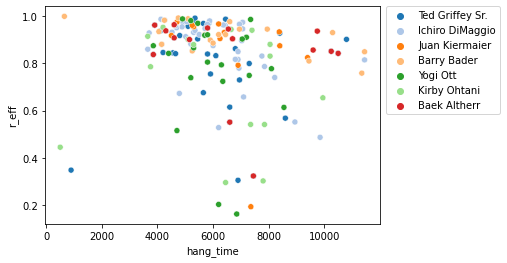

In [ ]:
import matplotlib.pyplot as plt
sns.set_palette('tab10')
sns.scatterplot(data=real,x='hang_time',y='r_eff',hue='name',legend=True,palette=sns.color_palette('tab20', n_colors=real['center_field'].nunique()))
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

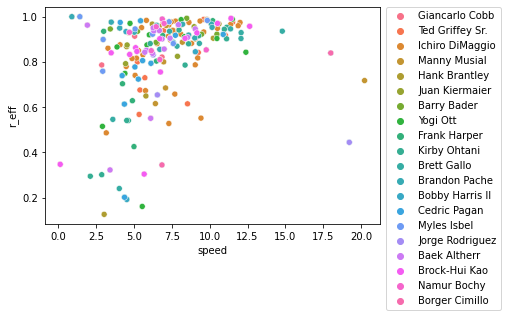

In [ ]:
sns.scatterplot(data=real,x='speed',y='r_eff',hue='name')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

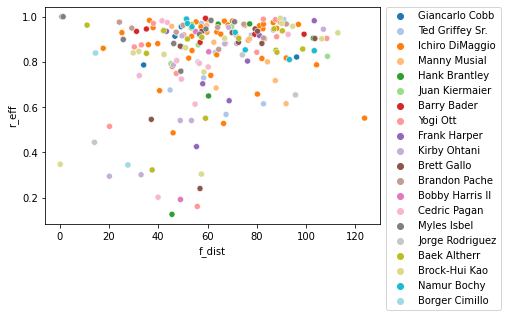

In [ ]:
sns.scatterplot(data=real,x='f_dist',y='r_eff',hue='name',legend=True,palette=sns.color_palette('tab20', n_colors=real['center_field'].nunique()))
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

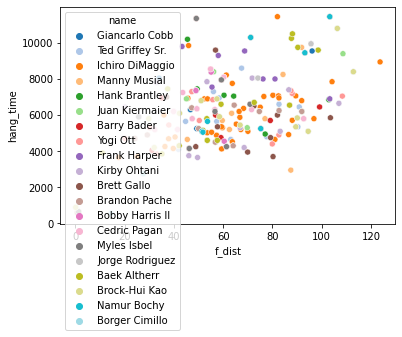

In [ ]:
sns.scatterplot(data=real,x='f_dist',y='hang_time',hue='name',legend=True,palette=sns.color_palette('tab20', n_colors=real['center_field'].nunique()))

# Show Potential Future Steps (Modeling the Metrics